In [ ]:
! pip install pickle-mixin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pickle-mixin: filename=pickle_mixin-1.0.2-py3-none-any.whl size=6006 sha256=f997d844310fd5e9f7d23a0a26ebcb00e5101e532ef5f29d9b5385772a5a0fad
  Stored in directory: /root/.cache/pip/wheels/d0/70/0b/673e09a7ed429660d22352a1b117b4f616a8fc054bdd7eb157
Successfully built pickle-mixin


In [ ]:
# 워닝 은닉
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
# 라이브러리 import
import pickle
import pandas as pd
import numpy as np
import re

In [ ]:
# 시각화 라이브러리 import
import seaborn as sns
import matplotlib.pyplot as plt  
import matplotlib as mpl    
import matplotlib.mlab as mlab
import matplotlib.cm as cm

#그래프 시각화 옵션 설정함수
%matplotlib inline

sns.set(style="ticks", color_codes=True, font_scale=1.2)
color = sns.color_palette()
sns.set_style('darkgrid')

#그래프의 한글을 더욱 선명하게 출력
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

#그래프에서 음수 값이 나올 때, 깨지는 현상 방지
mpl.rc('axes',unicode_minus=False)

In [ ]:
# from sklearn import metrics
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
# from scipy import stats
# from scipy.stats import skew, norm, probplot, boxcox
from scipy.stats import norm, probplot
from scipy.spatial.distance import cdist
# import datetime
import math

In [ ]:
# row 생략 없이 출력
pd.set_option('display.max_rows', None)
# 문자열 출력 길이
pd.options.display.max_colwidth = 2000

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# row 데이터 불러오기
with open('/content/drive/MyDrive/CP2/df_sentiment.pickle', 'rb') as f:
    data = pickle.load(f)

In [ ]:
df = data.copy()
# temp = data.sample(1000)

In [ ]:
# 긍정 확률값 컬럼 생성
def positive_score(dic):
    return dic['positive']
df['positive_score'] = df['labels_sh'].apply(positive_score)

In [ ]:
# 필요한 컬럼만 선택
columns = ["type", "id type", "created_at", "channel_name_secured", "sender_nick_id", "positive_score"]
df = df[columns]

In [ ]:
# celeb 제거
celeb = df[df["id type"] == "celeb"].index
df.drop(celeb, inplace=True)

In [ ]:
# 파일 타입 제거
File = df[df.type == "FILE"].index
df.drop(File, inplace=True)

In [ ]:
# 전송 날짜 타입 변경 object -> datetime
df['created_at'] = pd.to_datetime(df['created_at'])

In [ ]:
# celeb_id = list(temp["channel_name_secured"].unique())

In [ ]:
# RFM 생성
recency = df.groupby(["channel_name_secured"]).agg({"created_at":"max"})
frequency = df.groupby(["channel_name_secured"]).agg({"positive_score":"count"})
monetary = df.groupby(["channel_name_secured"]).agg({"positive_score":"sum"})

rfm = pd.merge(recency,frequency,how='left',on='channel_name_secured')
rfm = pd.merge(rfm,monetary,how='left',on='channel_name_secured')
rfm.rename(columns = {"created_at" : "recency", "positive_score_x" : "frequency", "positive_score_y" : "monetary"}, inplace=True)

In [ ]:
# 2022년 03월 01일 13시 43분 28초가 첫 메세지 전송 시간 : 넉넉하게 2022-01-01 00:00:00을 기준으로 설정
current_day = pd.to_datetime('2022-02-28')
# current_day = pd.to_datetime('2022-01-01 00:00:00')
# 최근방문일과 기준 날짜의 시간 차이
time_diff = rfm['recency'] - current_day
# 시간 차이를 초단위로 계산
time_in_seconds = [round(x.total_seconds() / 86400) for x in time_diff] 
# 변환된 데이터를 다시 삽입한다.
rfm['recency'] = time_in_seconds

In [ ]:
pd.options.display.float_format = '{:.5f}'.format
rfm.describe()

,recency,frequency,monetary
count,268.00000,268.00000,268.00000
mean,198.26493,1142.17910,464.10188
std,18.11844,3520.82605,1759.49521
min,0.00000,1.00000,0.05812
25%,199.00000,24.75000,10.03376
50%,201.00000,195.00000,78.94979
75%,202.00000,742.50000,277.09642
max,202.00000,31914.00000,20444.37045


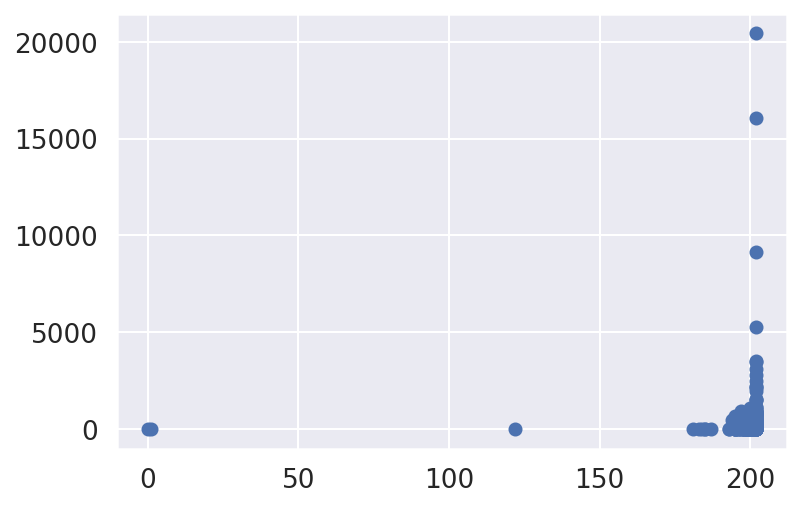

In [ ]:
plt.scatter(x=rfm.recency, y=rfm.monetary)

In [ ]:
rfm[rfm.recency < 130]

,recency,frequency,monetary
channel_name_secured,,,
he****,1,1,0.47541
jm*******,0,1,0.12458
유잼*,122,10,2.69657


In [ ]:
# 아웃라이어 제거
outlier = rfm[rfm.recency < 130].index
rfm.drop(outlier, inplace=True)

In [ ]:
# RFM 분포 시각화 함수
def QQ_plot(data, measure):
    fig = plt.figure(figsize=(20,7))

    #Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(data)

    #Kernel Density plot
    fig1 = fig.add_subplot(121)
    sns.distplot(data, fit=norm)
    fig1.set_title(measure + ' Distribution ( mu = {:.2f} and sigma = {:.2f} )'.format(mu, sigma), loc='center')
    fig1.set_xlabel(measure)
    fig1.set_ylabel('Frequency')

    #QQ plot
    fig2 = fig.add_subplot(122)
    res = probplot(data, plot=fig2)
    fig2.set_title(measure + ' Probability Plot (skewness: {:.6f} and kurtosis: {:.6f} )'.format(data.skew(), data.kurt()), loc='center')

    plt.tight_layout()
    plt.show()

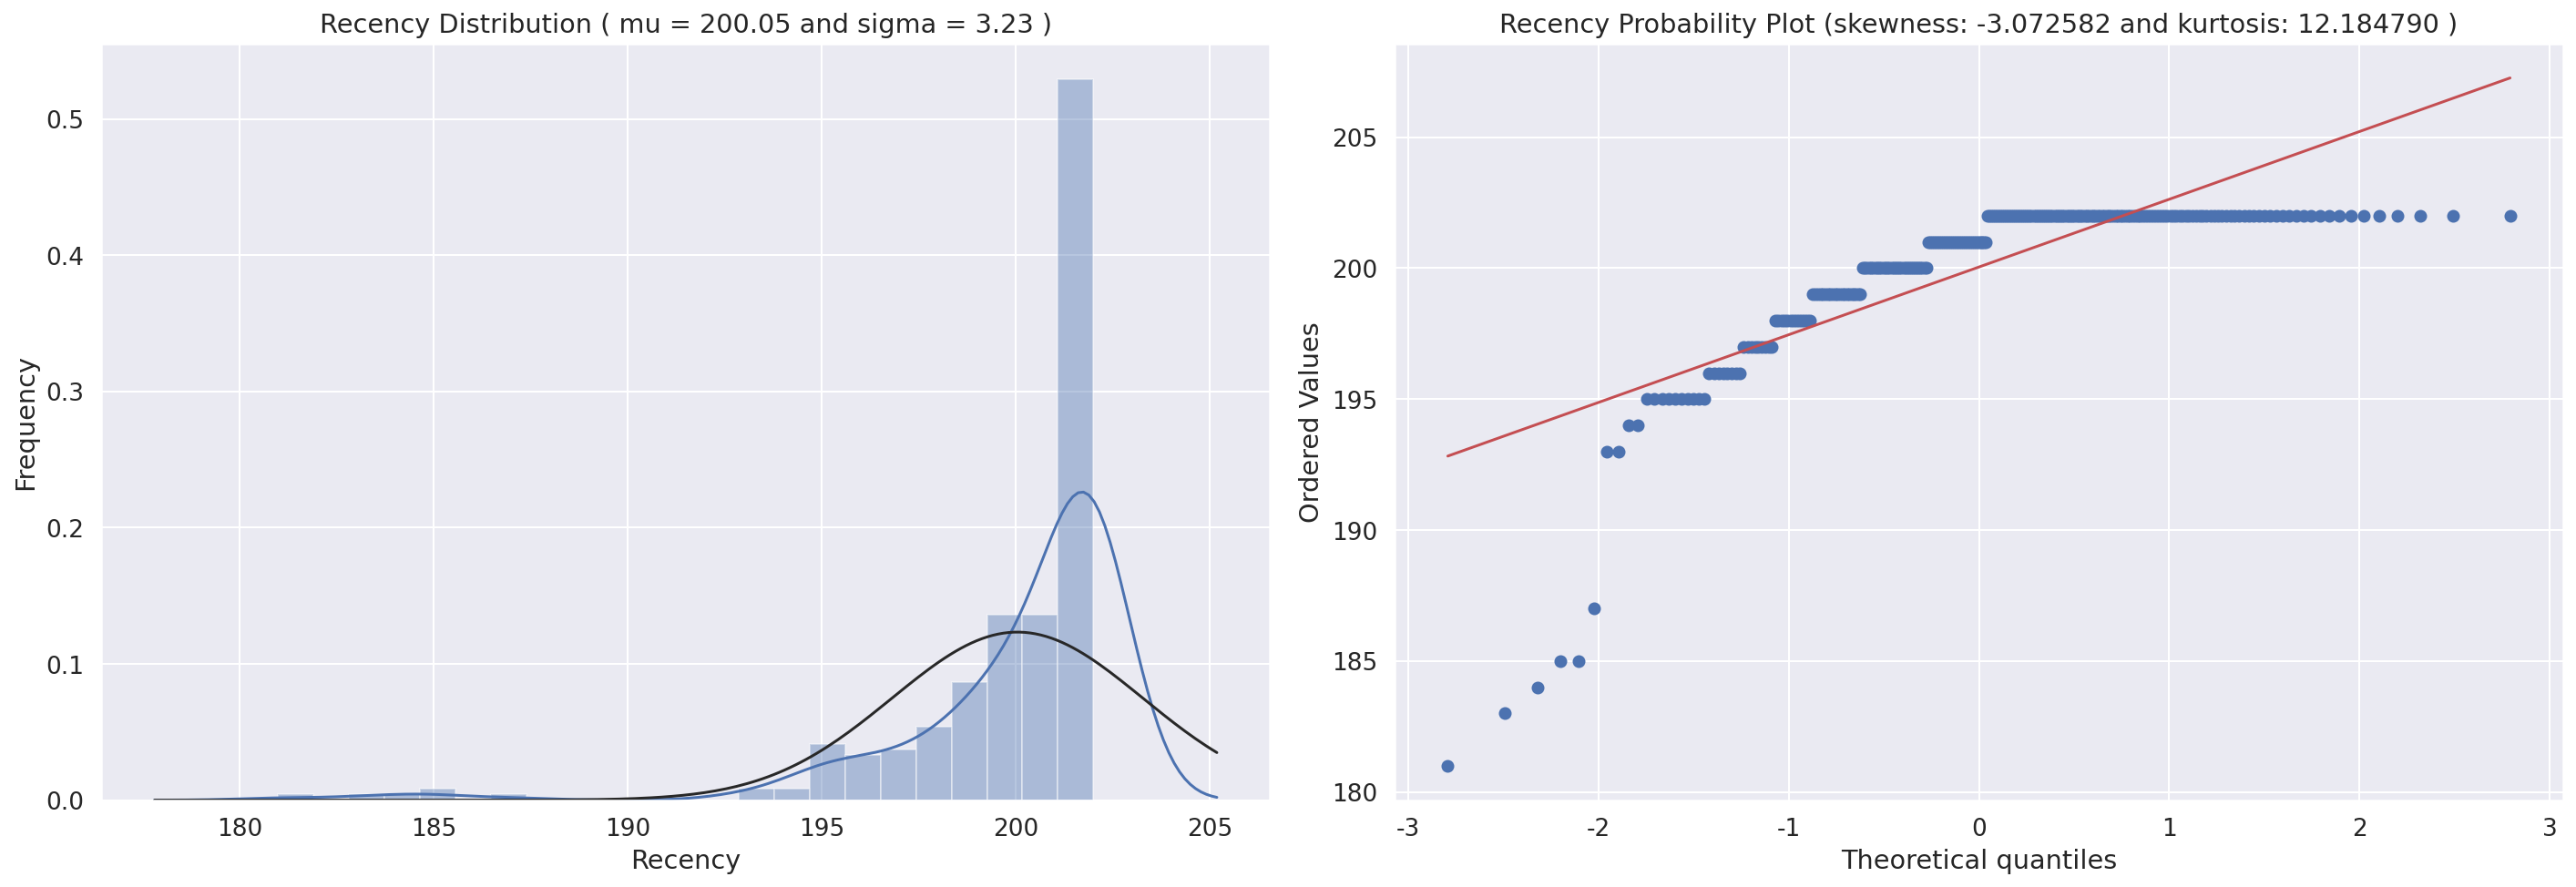

In [ ]:
QQ_plot(rfm.recency, 'Recency')

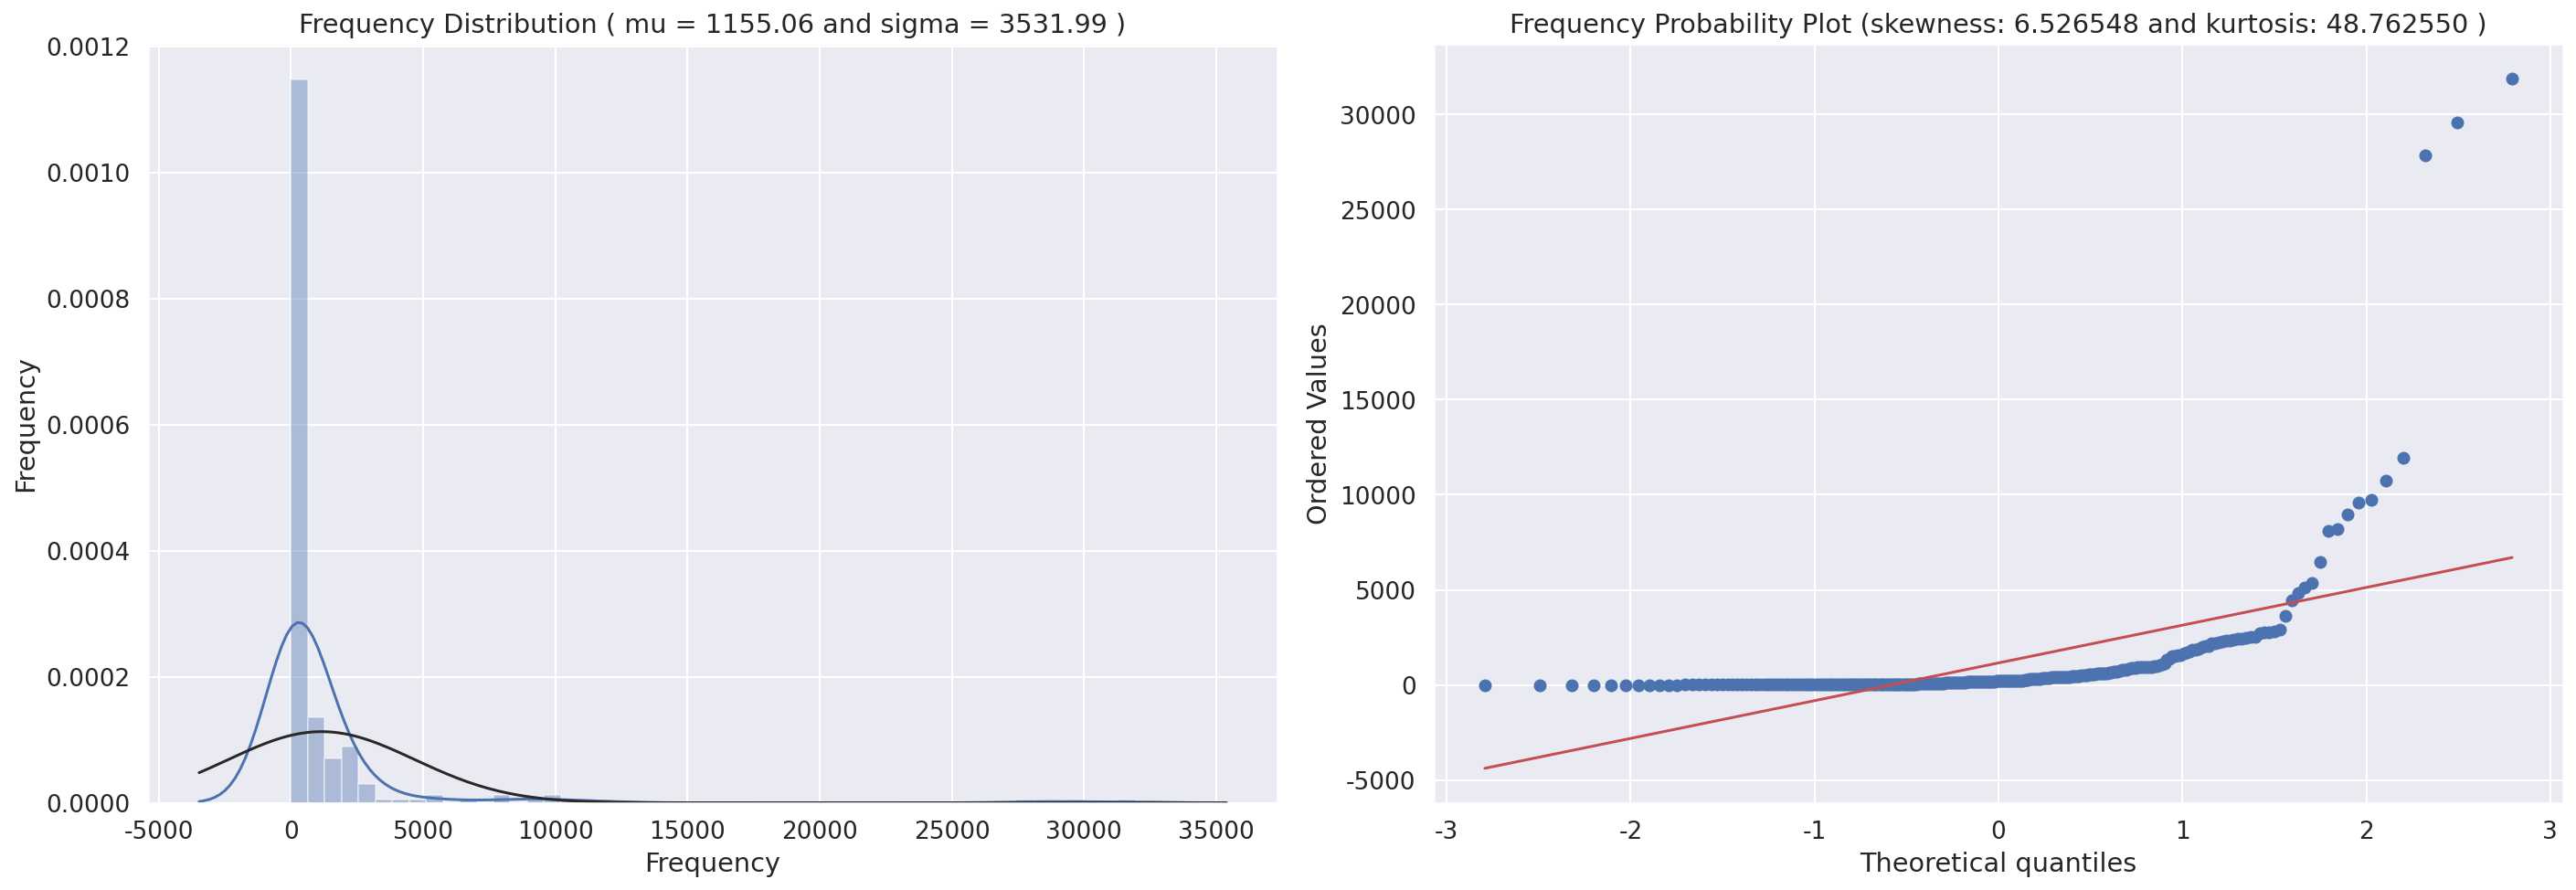

In [ ]:
QQ_plot(rfm.frequency, 'Frequency')

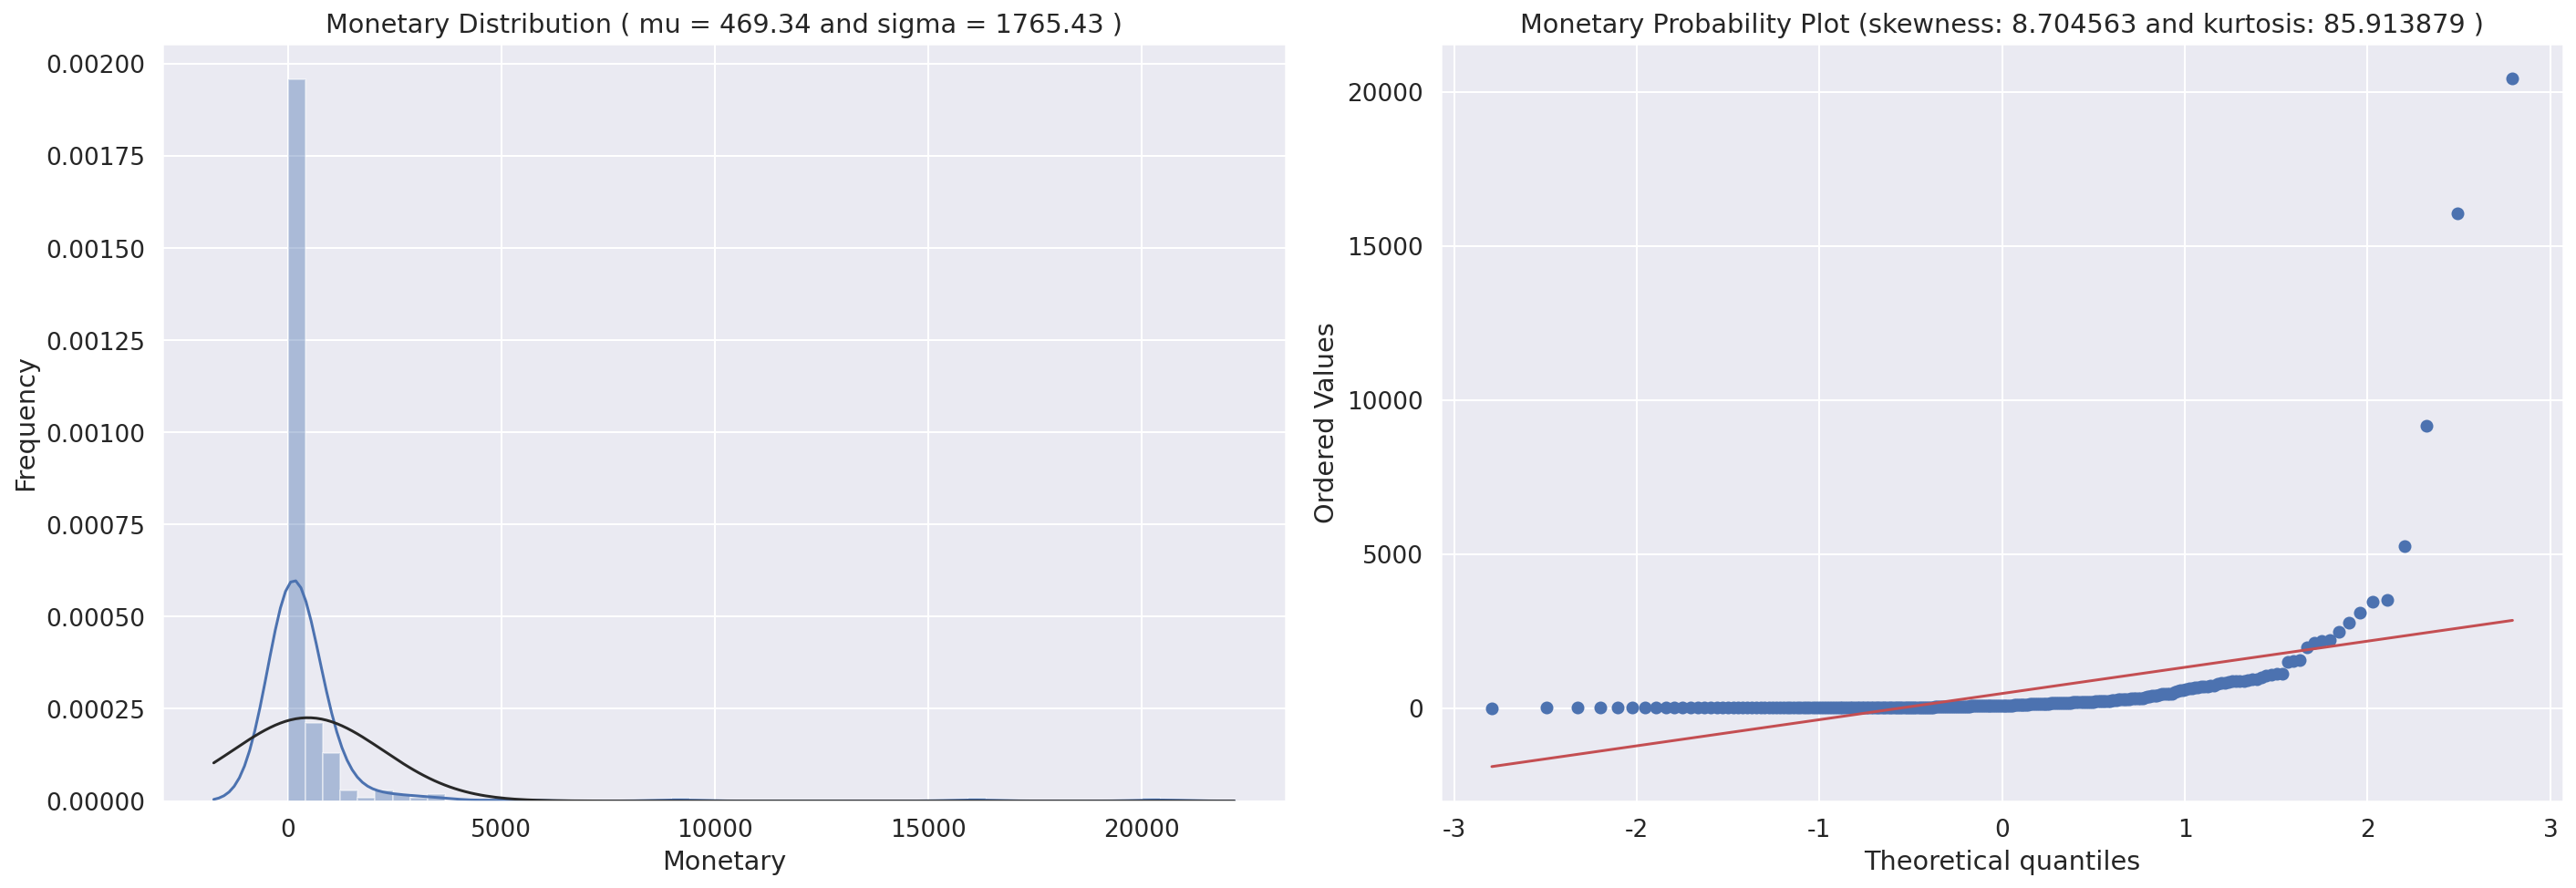

In [ ]:
QQ_plot(rfm.monetary, 'Monetary')

In [ ]:
# R, F, M 컬럼의 정규화를 위해 각각 log를 취함
rfm['Recency_log'] = np.log1p(rfm['recency'])
rfm['Frequency_log'] = np.log1p(rfm['frequency'])
rfm['Monetary_log'] = np.log1p(rfm['monetary'])

# rfm['Recency_log'] = rfm['recency'].apply(math.log)
# rfm['Frequency_log'] = rfm['frequency'].apply(math.log)
# rfm['Monetary_log'] = rfm['monetary'].apply(math.log)

features = ['Recency_log', 'Frequency_log','Monetary_log']

rfm_log = rfm[features]

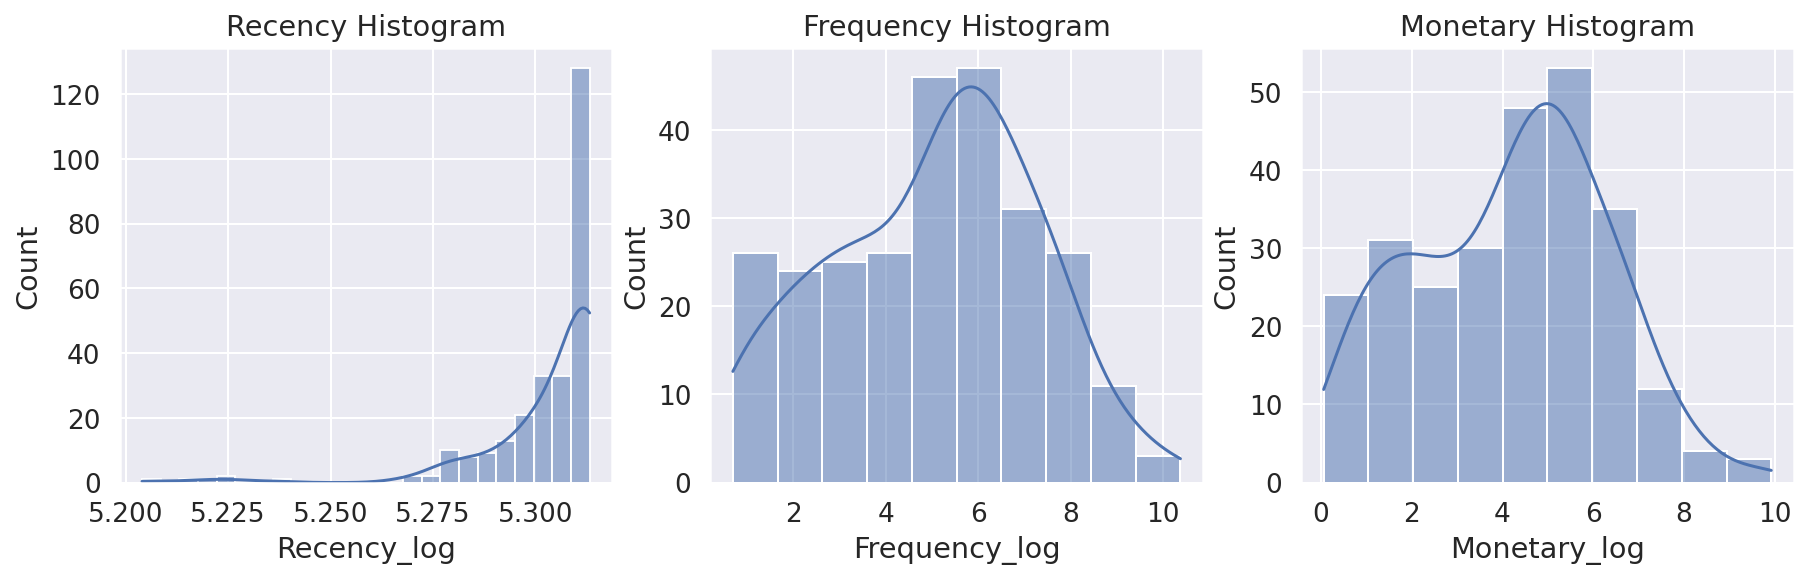

In [ ]:
# rfm_log 분포 확인
fig, axs = plt.subplots(1,3, figsize=(15,4))

sns.histplot(rfm_log['Recency_log'], kde=True, ax=axs[0])
axs[0].set_title('Recency Histogram')

sns.histplot(rfm_log['Frequency_log'], kde=True, ax=axs[1])
axs[1].set_title('Frequency Histogram')

sns.histplot(rfm_log['Monetary_log'], kde=True, ax=axs[2])
axs[2].set_title('Monetary Histogram')

plt.show()

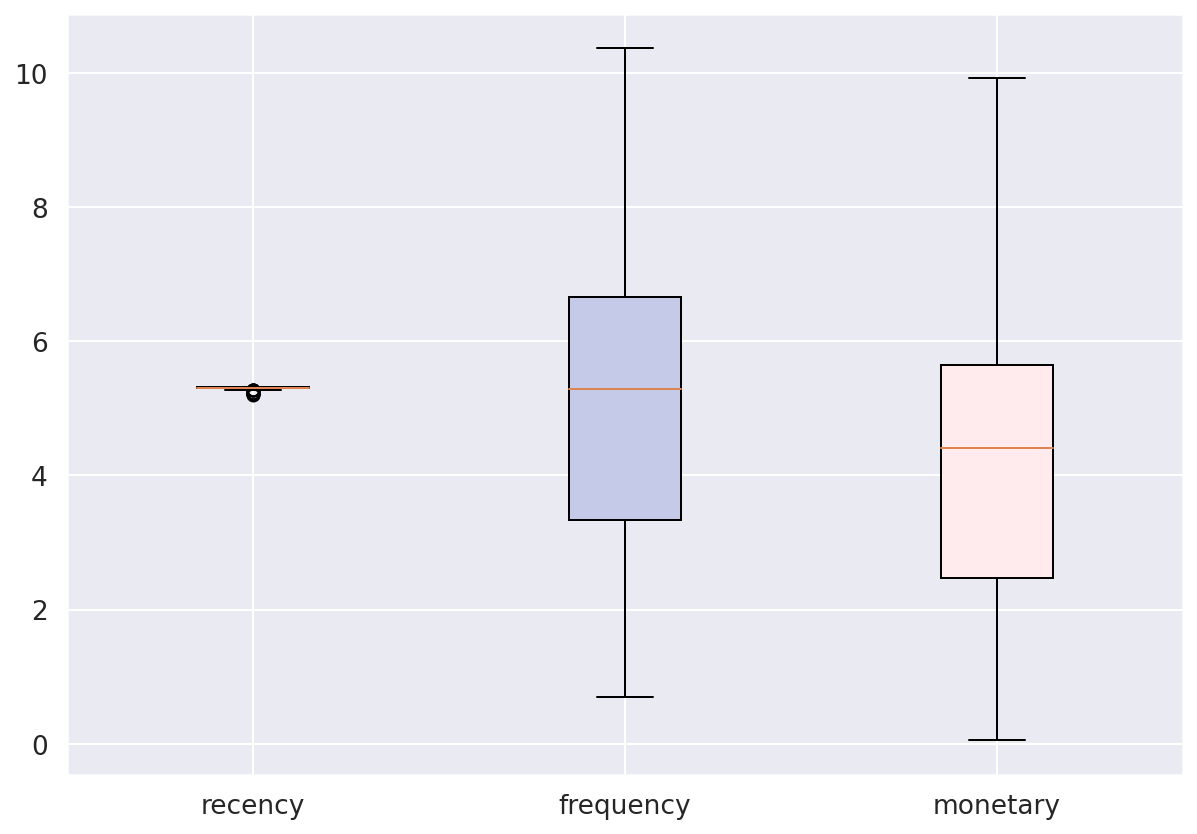

In [ ]:
data_1 = rfm_log["Recency_log"]
data_2 = rfm_log["Frequency_log"]
data_3 = rfm_log["Monetary_log"]
data = [data_1, data_2, data_3]

fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)
ax.set_xticklabels(['recency', 'frequency', 'monetary'])

bp = ax.boxplot(data, patch_artist = True, vert = 1)

colors = ['#e0f2f1', '#c5cae9', '#ffebee']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

plt.show(bp)

In [ ]:
# Standardization : 평균을 빼고 표준 편차로 나누어 평균이 0이고 표준 편차가 1이 되도록 분포를 이동
scaler = StandardScaler()
st = scaler.fit(rfm_log)
X_scaled = st.transform(rfm_log)
rfm_normalized = pd.DataFrame(X_scaled, columns = rfm_log.columns)
# rfm_normalized.rename(columns={0 : "recency", 1 : "frequency", 2 : "monetary"}, inplace=True)

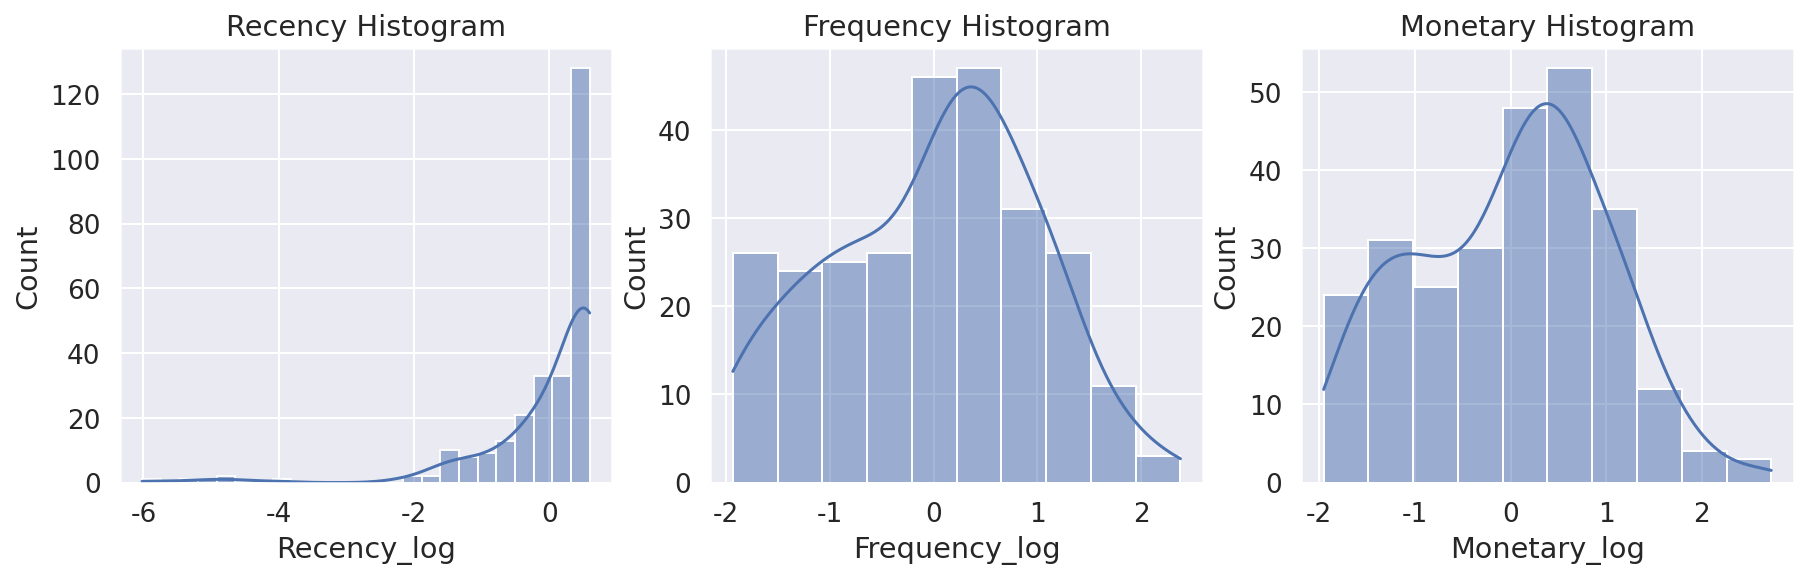

In [ ]:
# rfm_normalized 분포 확인
fig, axs = plt.subplots(1,3, figsize=(15,4))

sns.histplot(rfm_normalized['Recency_log'], kde=True, ax=axs[0])
axs[0].set_title('Recency Histogram')

sns.histplot(rfm_normalized['Frequency_log'], kde=True, ax=axs[1])
axs[1].set_title('Frequency Histogram')

sns.histplot(rfm_normalized['Monetary_log'], kde=True, ax=axs[2])
axs[2].set_title('Monetary Histogram')

plt.show()

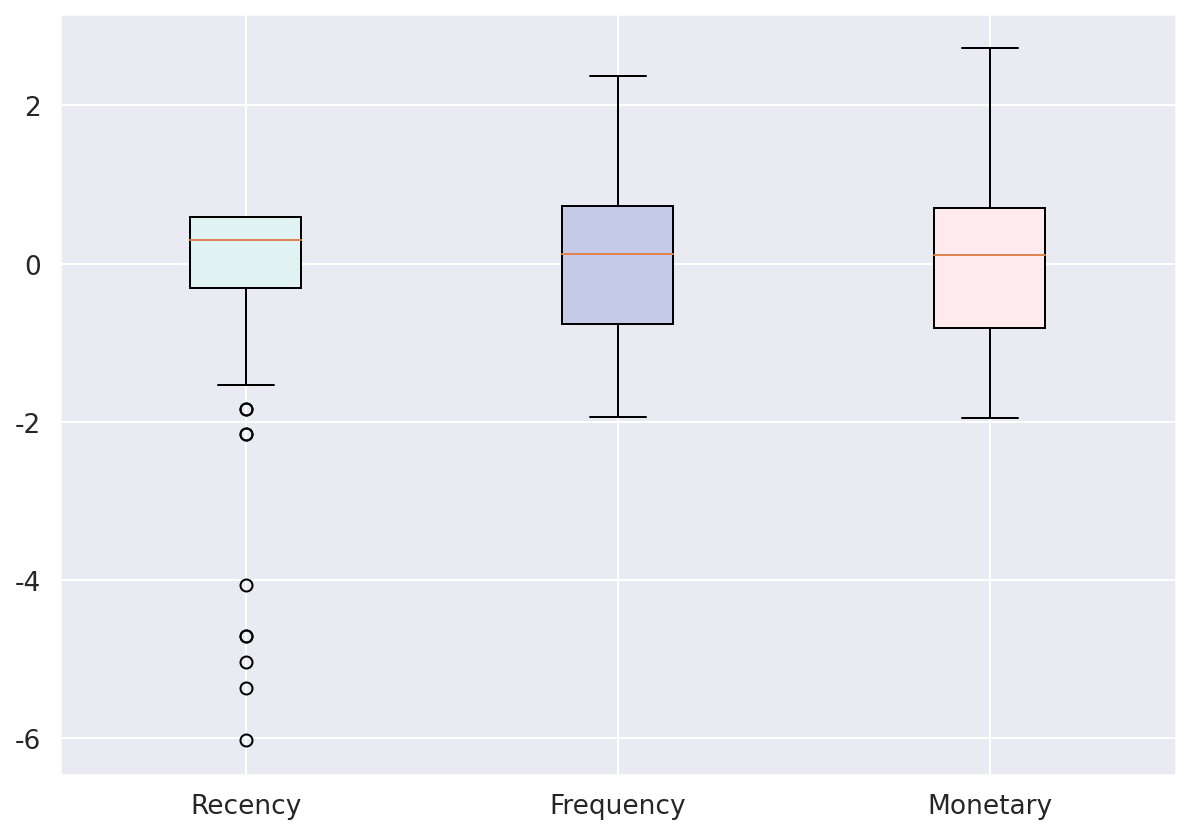

In [ ]:
data_1 = rfm_normalized["Recency_log"]
data_2 = rfm_normalized["Frequency_log"]
data_3 = rfm_normalized["Monetary_log"]
data = [data_1, data_2, data_3]

fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)
ax.set_xticklabels(['Recency', 'Frequency', 'Monetary'])

bp = ax.boxplot(data, patch_artist = True, vert = 1)

colors = ['#e0f2f1', '#c5cae9', '#ffebee']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

plt.show(bp)

## 클러스터링

In [ ]:
# Elbow Method : 적정 군집수 확인
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(rfm_normalized) 
    kmeanModel.fit(rfm_normalized)     
      
    distortions.append(sum(np.min(cdist(rfm_normalized, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / rfm_normalized.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(rfm_normalized, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / rfm_normalized.shape[0] 
    mapping2[k] = kmeanModel.inertia_

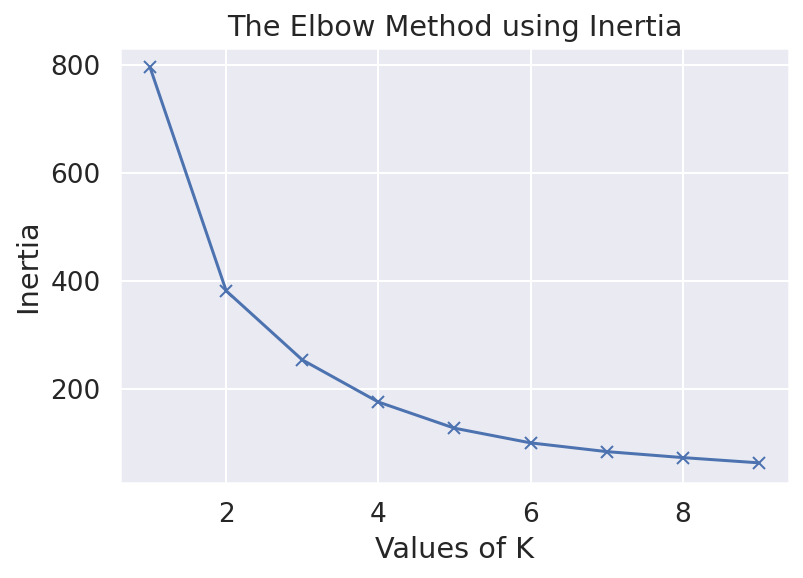

In [ ]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

In [ ]:
# 실루엣
def visualize_kmeans(cluster_list,feature_columns,X):
  cluster_centers = dict()
  for n_clusters in cluster_list:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_size_inches(20, 6)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10,max_iter=300, tol=1e-04, random_state=123)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X = X, labels = cluster_labels)
    cluster_centers.update({n_clusters :{'cluster_center':clusterer.cluster_centers_,
                                         'silhouette_score':silhouette_avg,
                                         'labels':cluster_labels}
                           })

    sample_silhouette_values = silhouette_samples(X = X, labels = cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.Spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  

    ax1.set_title("The silhouette plot for the various clusters")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
    colors = cm.Spectral(cluster_labels.astype(float) / n_clusters)
    
    centers = clusterer.cluster_centers_
    y = 0
    x = 1
    ax2.scatter(X[:, x], X[:, y], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')   
    ax2.scatter(centers[:, x], centers[:, y], marker='o', c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[x], c[y], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
    ax2.set_title("{} Clustered data".format(n_clusters))
    ax2.set_xlabel(features[x])
    ax2.set_ylabel(features[y])

    x = 2
    ax3.scatter(X[:, x], X[:, y], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')   
    ax3.scatter(centers[:, x], centers[:, y], marker='o', c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax3.scatter(c[x], c[y], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
    ax3.set_title("Silhouette score: {:1.2f}".format(cluster_centers[n_clusters]['silhouette_score']))
    ax3.set_xlabel(features[x])
    ax3.set_ylabel(features[y])
    
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
  return cluster_centers

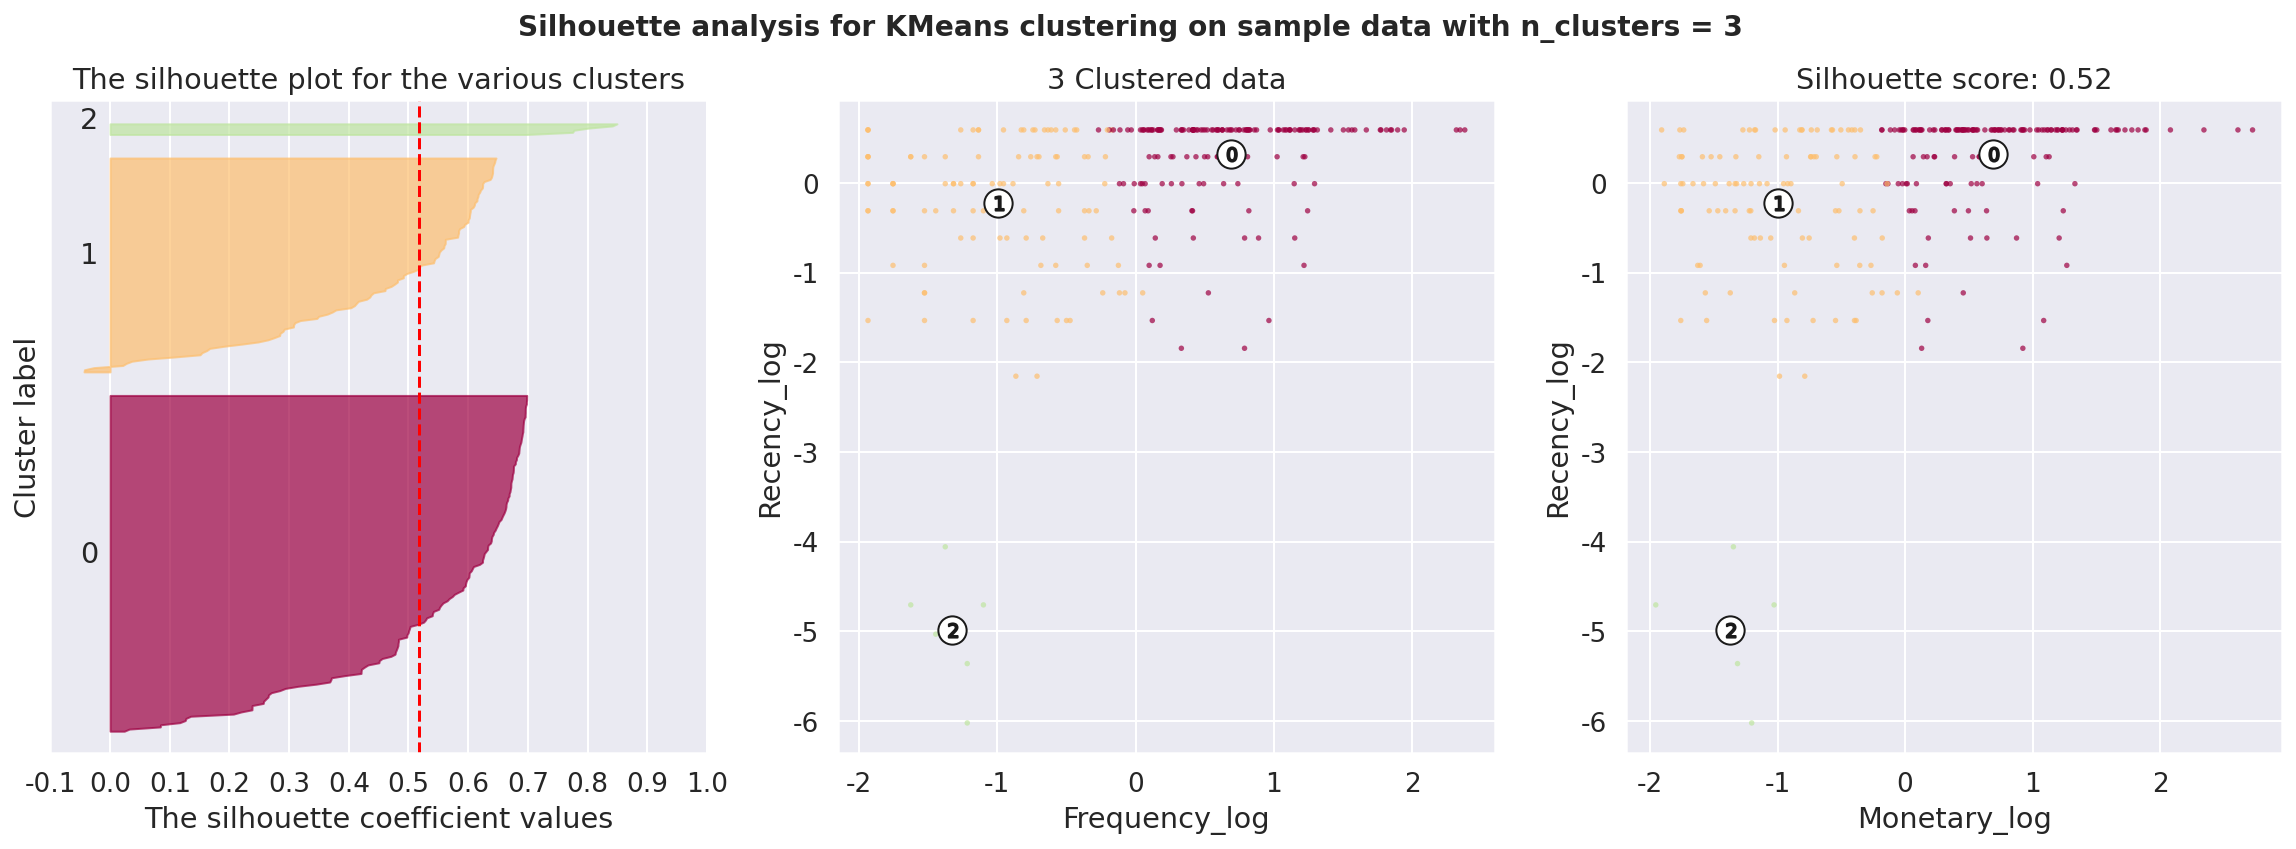

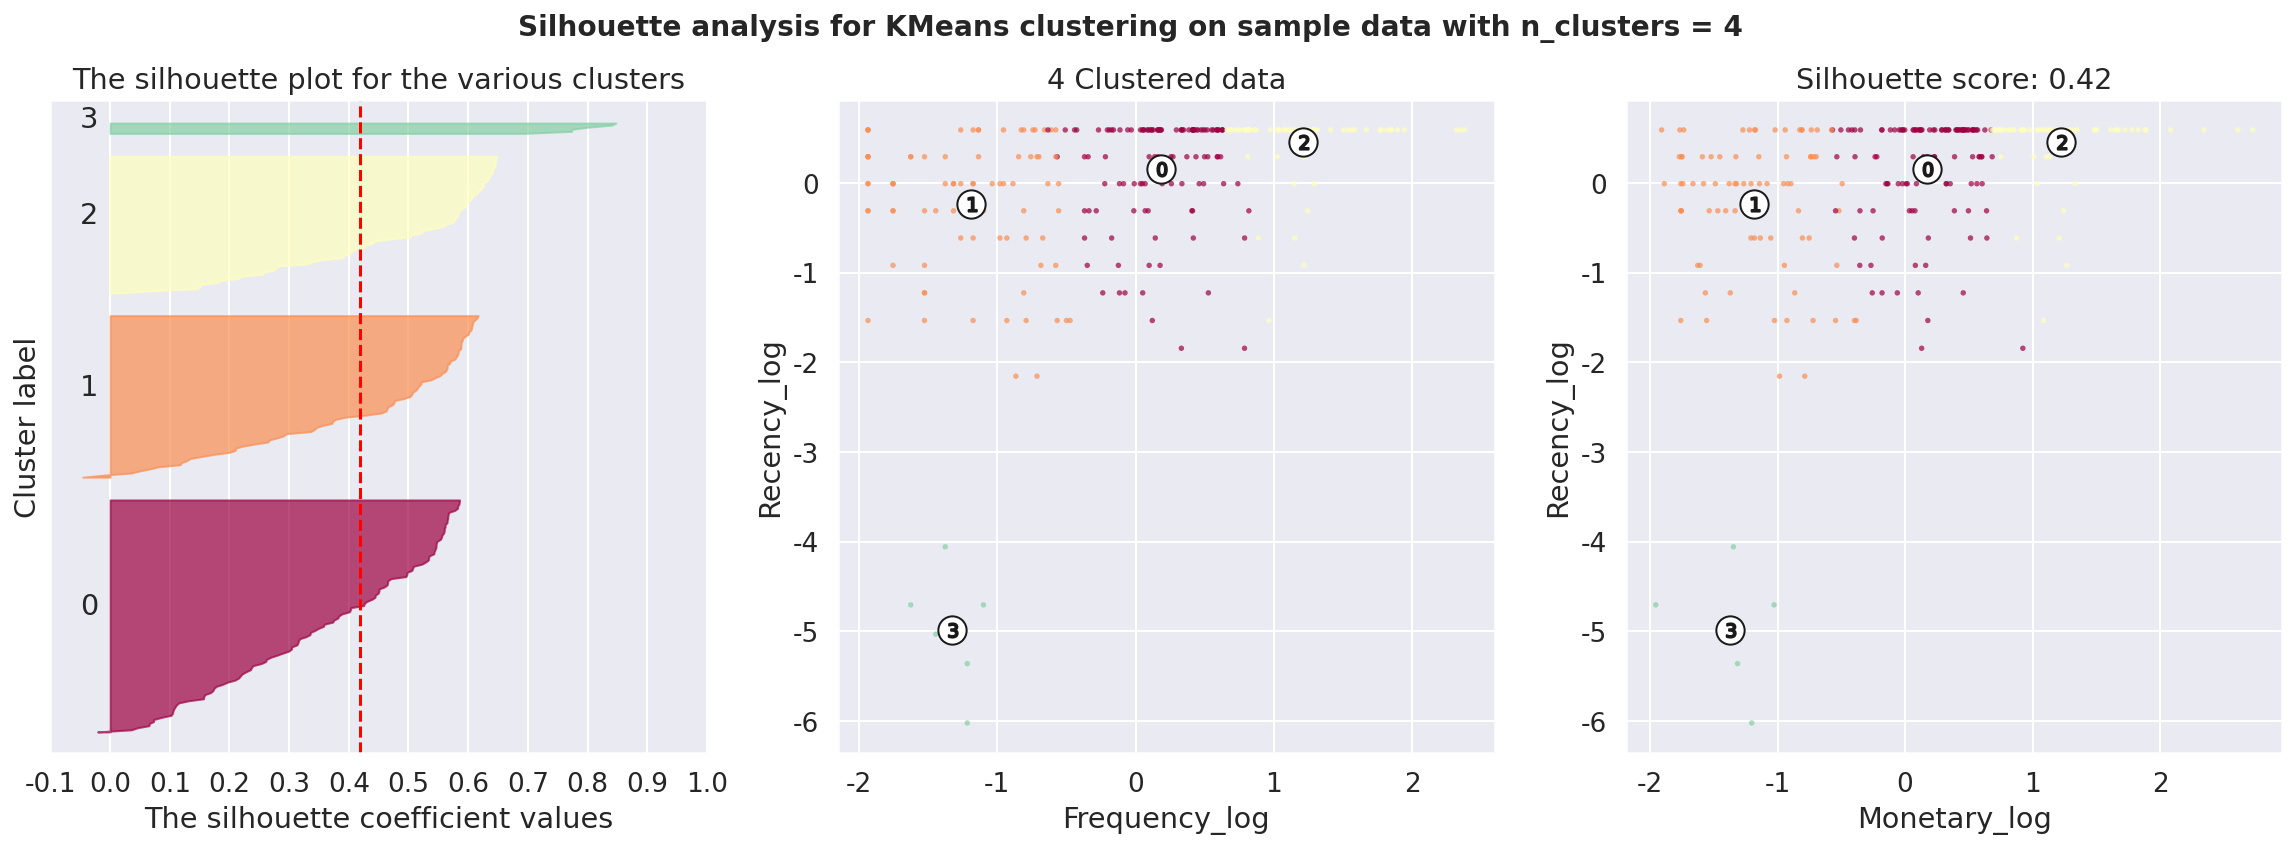

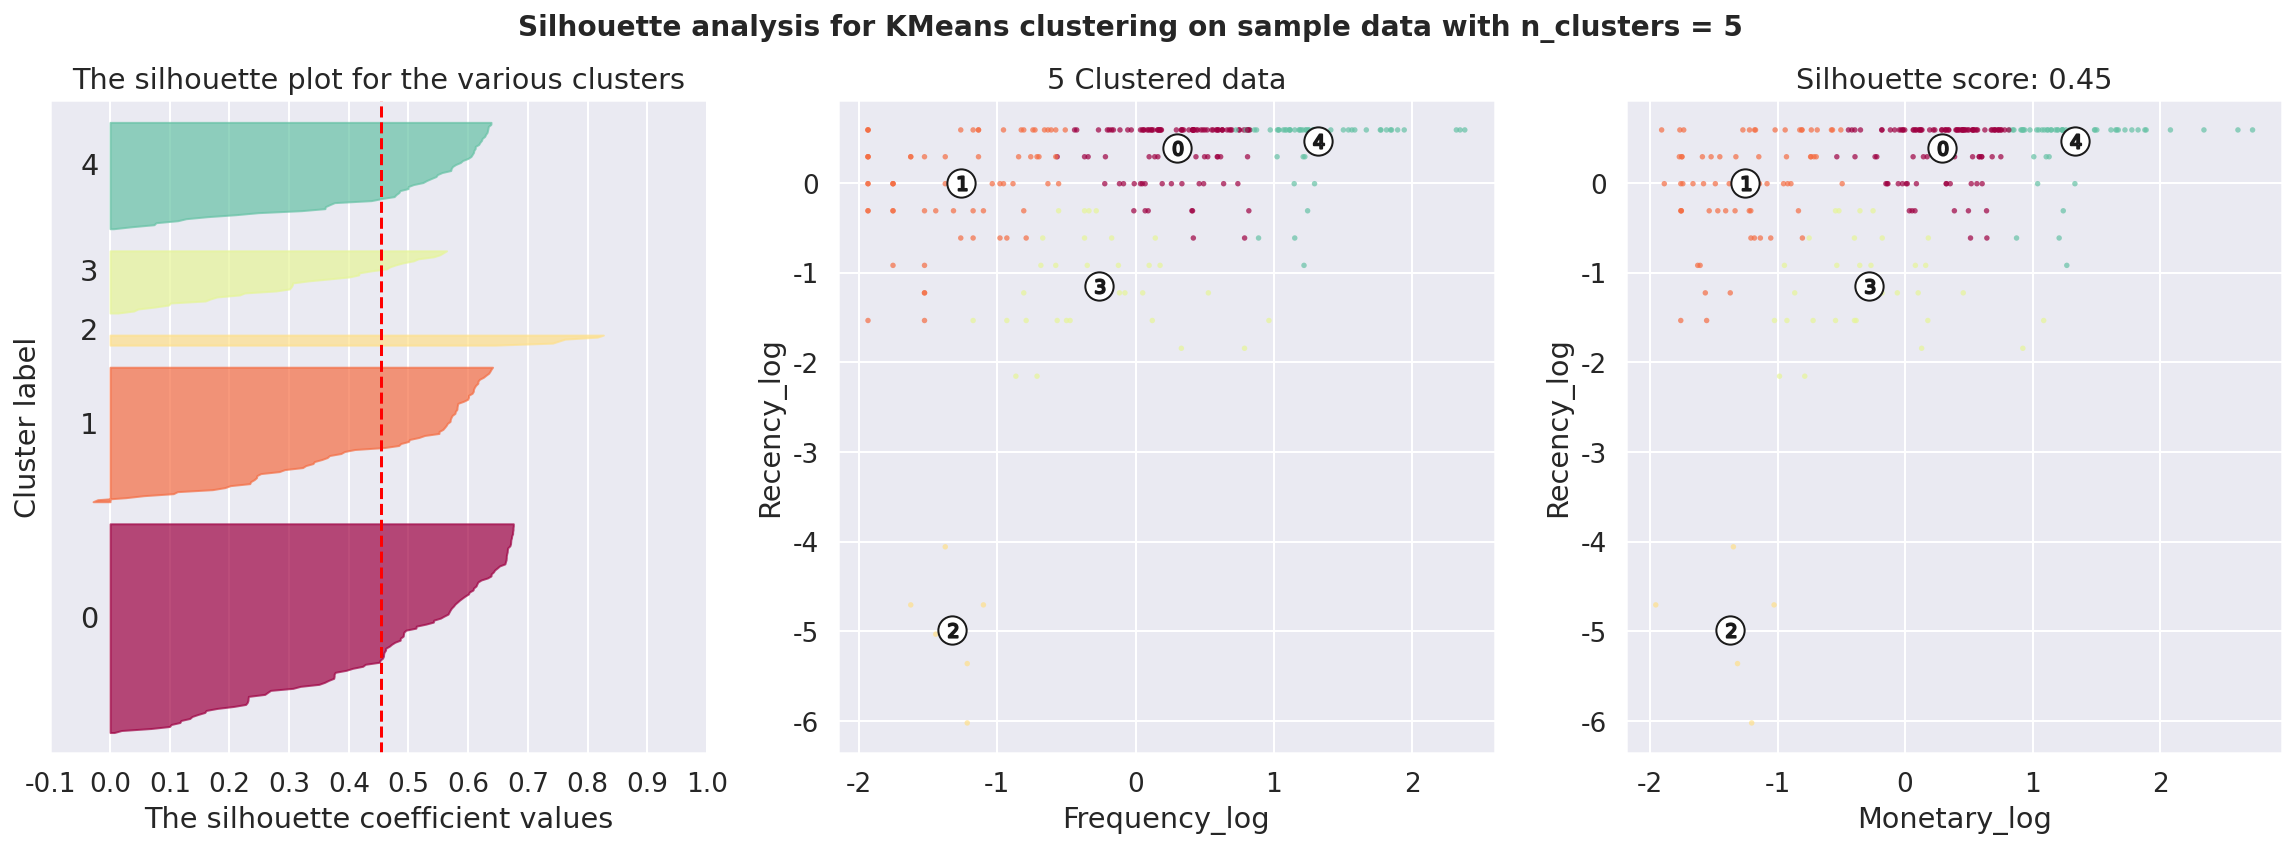

In [ ]:
# K = 3, 4, 5 일때 결과를 시각화하고 이때 cluster별 중심을 저장
cluster_centers=visualize_kmeans([3,4,5], features, X_scaled)

In [ ]:
# 군집별 군집의 중심점을 표출
for i in range(3,6):
    print("For {} clusters the silhouette score is {:1.2f}".format(i, cluster_centers[i]['silhouette_score']))
    print("Centers of each cluster:")
    cent_transformed = st.inverse_transform(cluster_centers[i]['cluster_center'])
    print(pd.DataFrame(np.exp(cent_transformed),columns=features))
    print('-'*50)

For 3 clusters the silhouette score is 0.52
Centers of each cluster:
   Recency_log  Frequency_log  Monetary_log
0    202.11967      714.44932     278.59510
1    200.28308       16.49289       8.03053
2    185.15727        7.76025       3.59092
--------------------------------------------------
For 4 clusters the silhouette score is 0.42
Centers of each cluster:
   Recency_log  Frequency_log  Monetary_log
0    201.53865      231.13803      94.35543
1    200.25159       10.65876       5.39259
2    202.53310     2326.42423     863.34365
3    185.15727        7.76025       3.59092
--------------------------------------------------
For 5 clusters the silhouette score is 0.45
Centers of each cluster:
   Recency_log  Frequency_log  Monetary_log
0    202.32118      297.84468     119.93058
1    201.03636        9.06683       4.66171
2    185.15727        7.76025       3.59092
3    197.24287       84.18040      36.25728
4    202.57097     2952.69399    1090.67587
-------------------------------

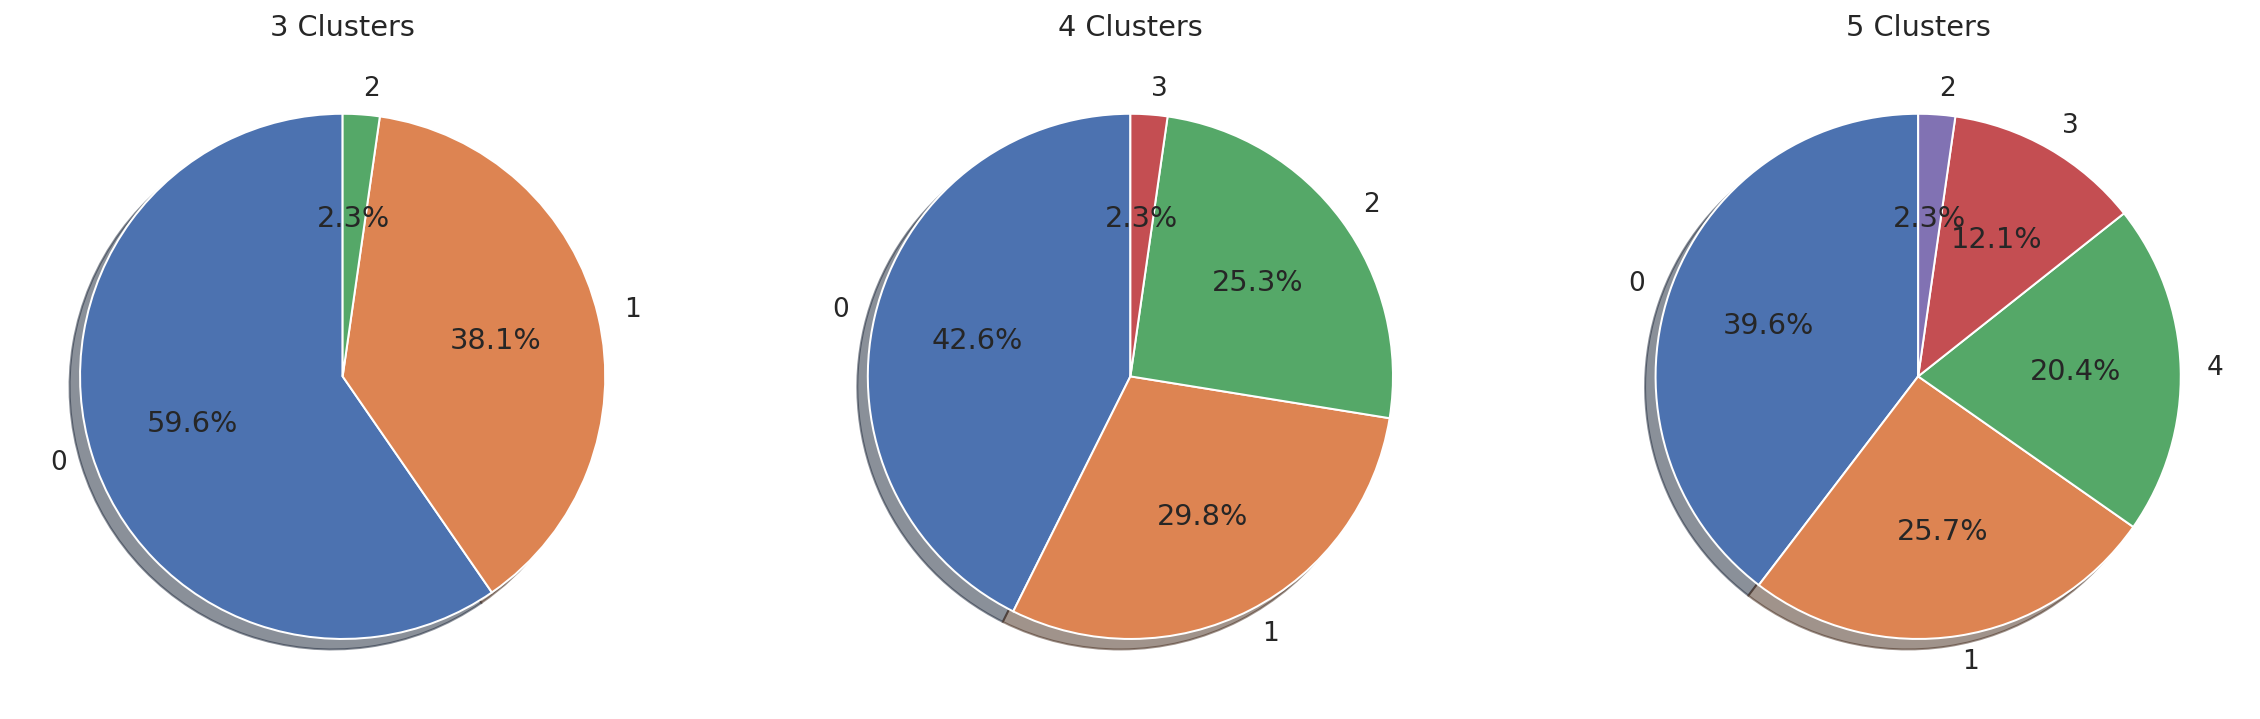

In [ ]:
rfm['clusters_3'] = cluster_centers[3]['labels'] 
rfm['clusters_4'] = cluster_centers[4]['labels']
rfm['clusters_5'] = cluster_centers[5]['labels']

fig = plt.figure(figsize=(20,7))
f1 = fig.add_subplot(131)
market = rfm.clusters_3.value_counts()
g = plt.pie(market, labels=market.index, autopct='%.1f%%', shadow=True, startangle=90)
plt.title('3 Clusters')

f1 = fig.add_subplot(132)
market = rfm.clusters_4.value_counts()
g = plt.pie(market, labels=market.index, autopct='%.1f%%', shadow=True, startangle=90)
plt.title('4 Clusters')

f1 = fig.add_subplot(133)
market = rfm.clusters_5.value_counts()
g = plt.pie(market, labels=market.index, autopct='%.1f%%', shadow=True, startangle=90)
plt.title('5 Clusters')
plt.show()

Recency In Cluster 3 & 4


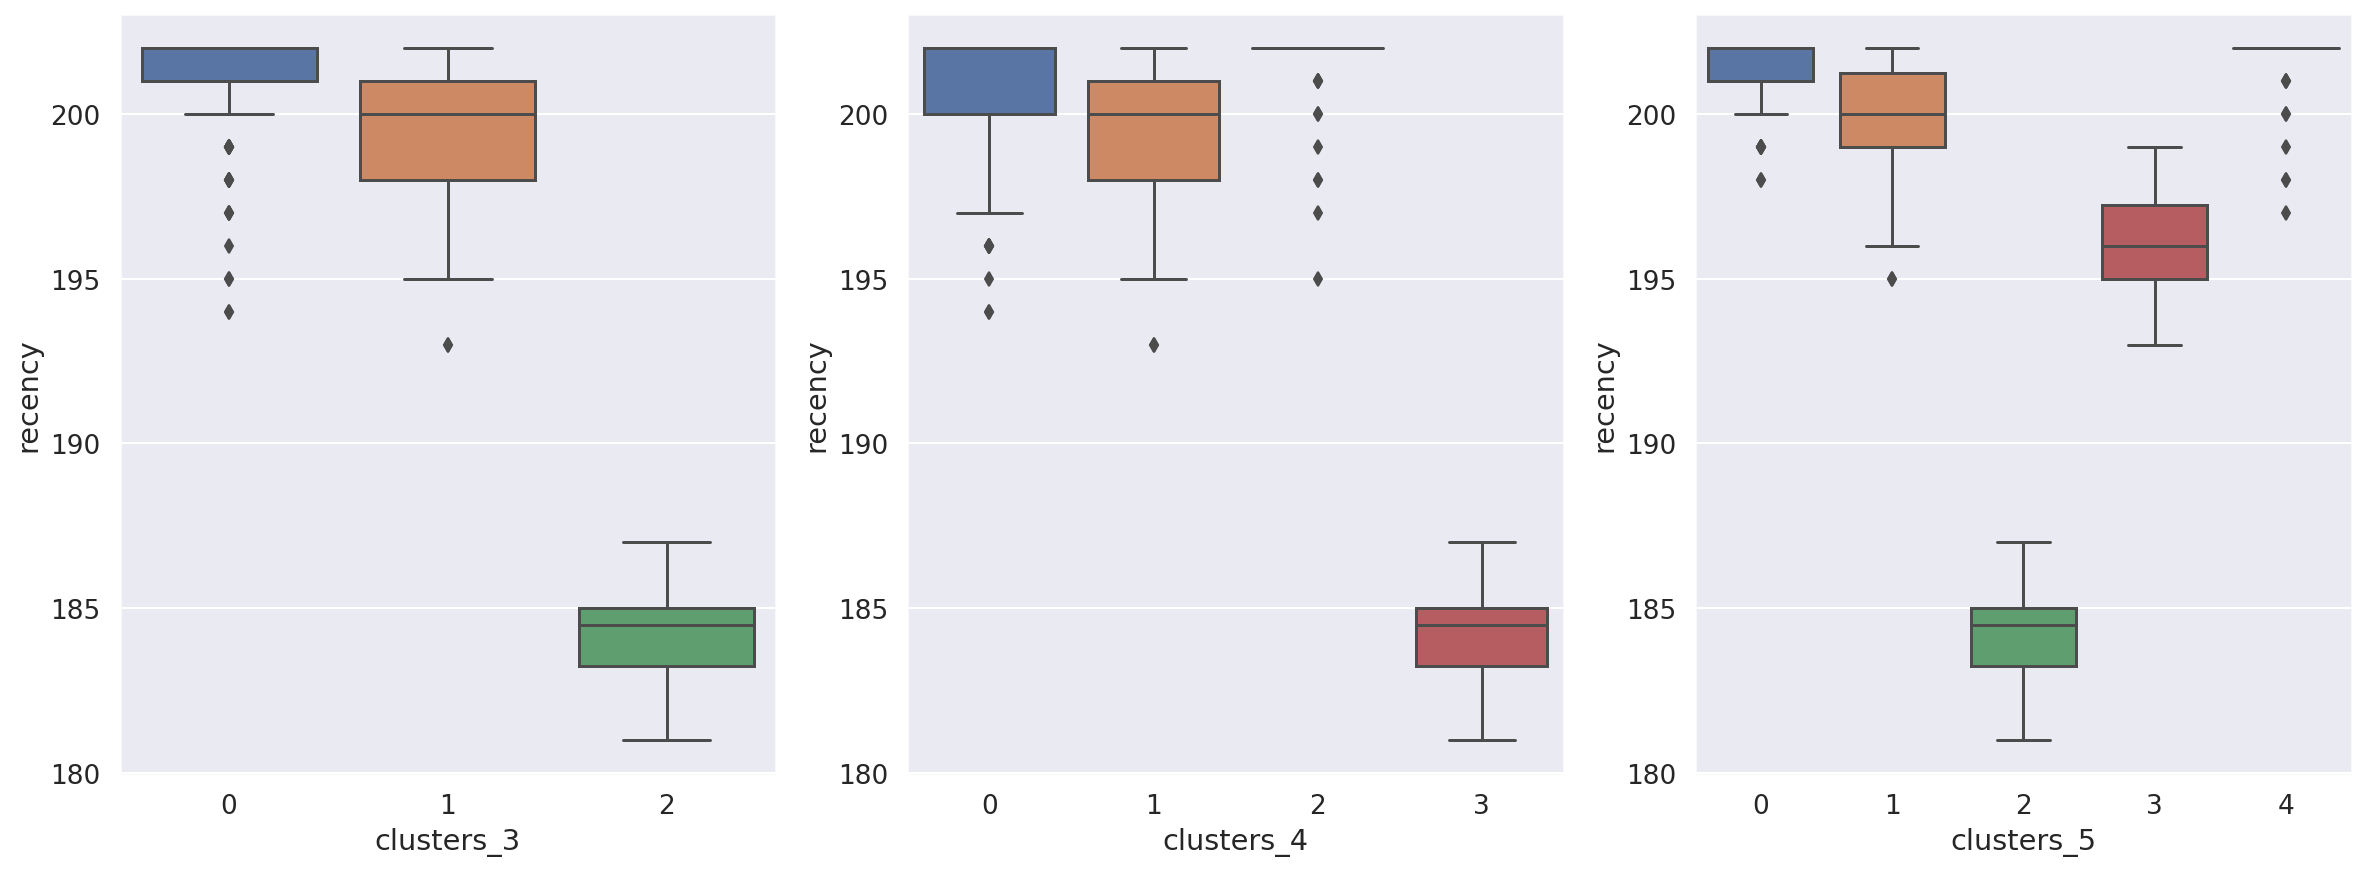

In [ ]:
print('Recency In Cluster 3 & 4')
fig = plt.figure(figsize=(20,7))
f1 = fig.add_subplot(131)
sns.boxplot(data=rfm,x='clusters_3',y='recency')

f1 = fig.add_subplot(132)
sns.boxplot(data=rfm,x='clusters_4',y='recency')

f1 = fig.add_subplot(133)
sns.boxplot(data=rfm,x='clusters_5',y='recency')

Frequency In Cluster 3 & 4


(0.0, 5000.0)

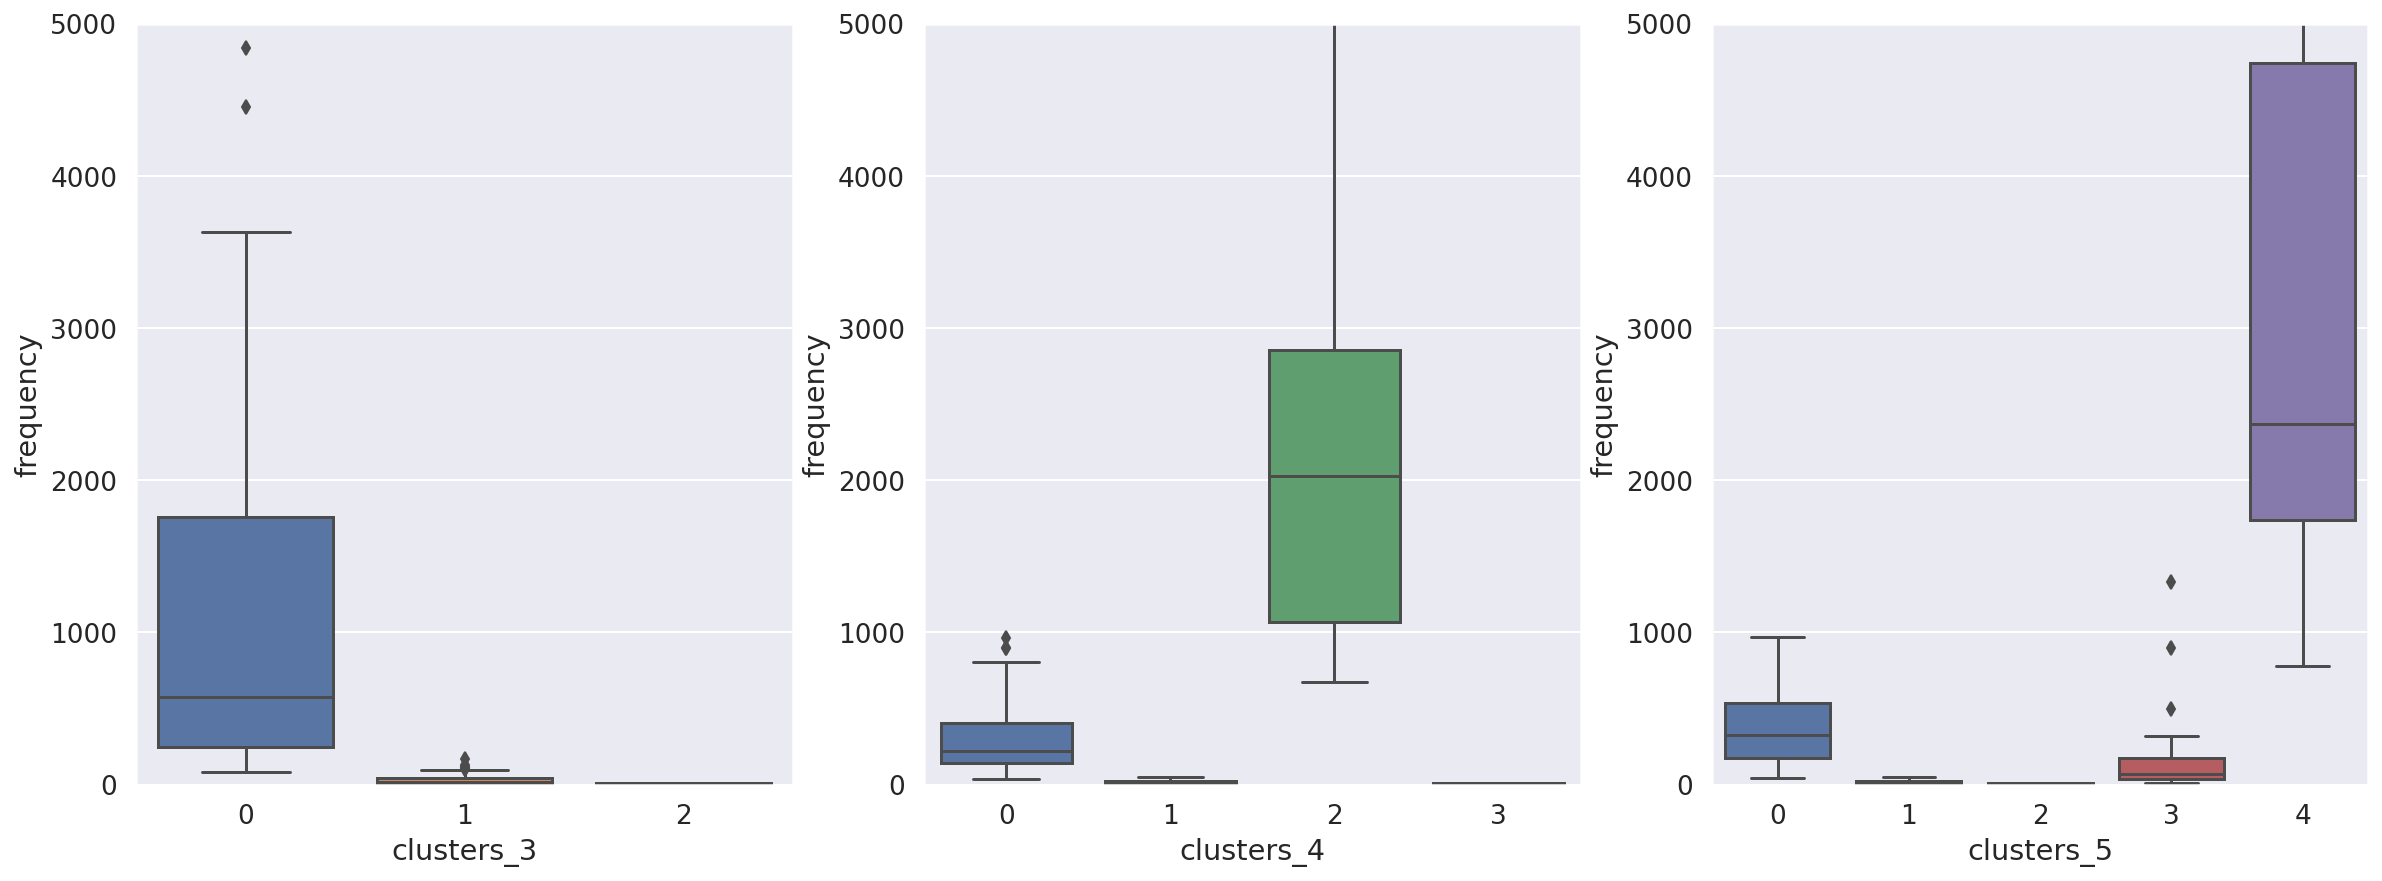

In [ ]:
print('Frequency In Cluster 3 & 4')
fig = plt.figure(figsize=(20,7))
f1 = fig.add_subplot(131)
sns.boxplot(data=rfm,x='clusters_3',y='frequency')
plt.ylim(0,5000)

f1 = fig.add_subplot(132)
sns.boxplot(data=rfm,x='clusters_4',y='frequency')
plt.ylim(0,5000)

f1 = fig.add_subplot(133)
sns.boxplot(data=rfm,x='clusters_5',y='frequency')
plt.ylim(0,5000)

Monetary In Cluster 3 & 4


(0.0, 2000.0)

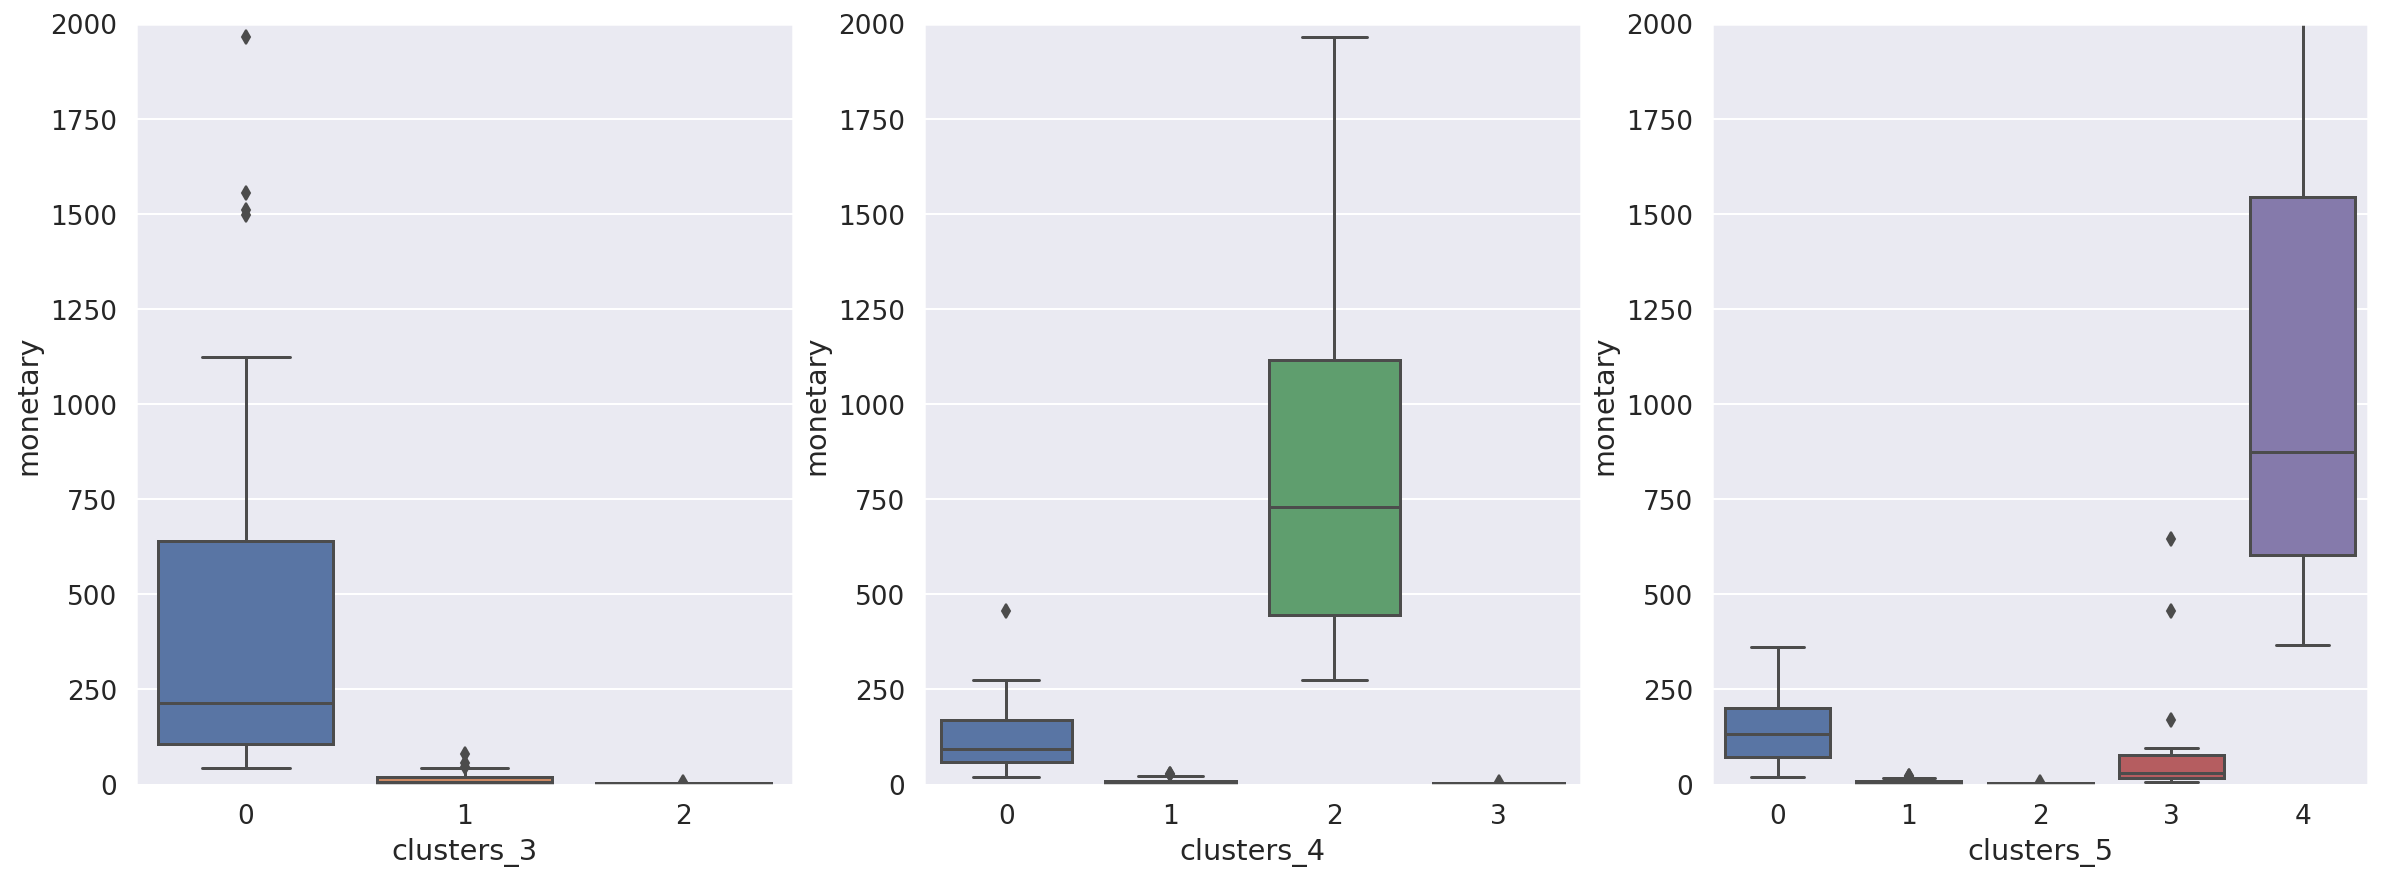

In [ ]:
print('Monetary In Cluster 3 & 4')
fig = plt.figure(figsize=(20,7))
f1 = fig.add_subplot(131)
sns.boxplot(data=rfm,x='clusters_3',y='monetary')
plt.ylim(0,2000)

f1 = fig.add_subplot(132)
sns.boxplot(data=rfm,x='clusters_4',y='monetary')
plt.ylim(0,2000)

f1 = fig.add_subplot(133)
sns.boxplot(data=rfm,x='clusters_5',y='monetary')
plt.ylim(0,2000)

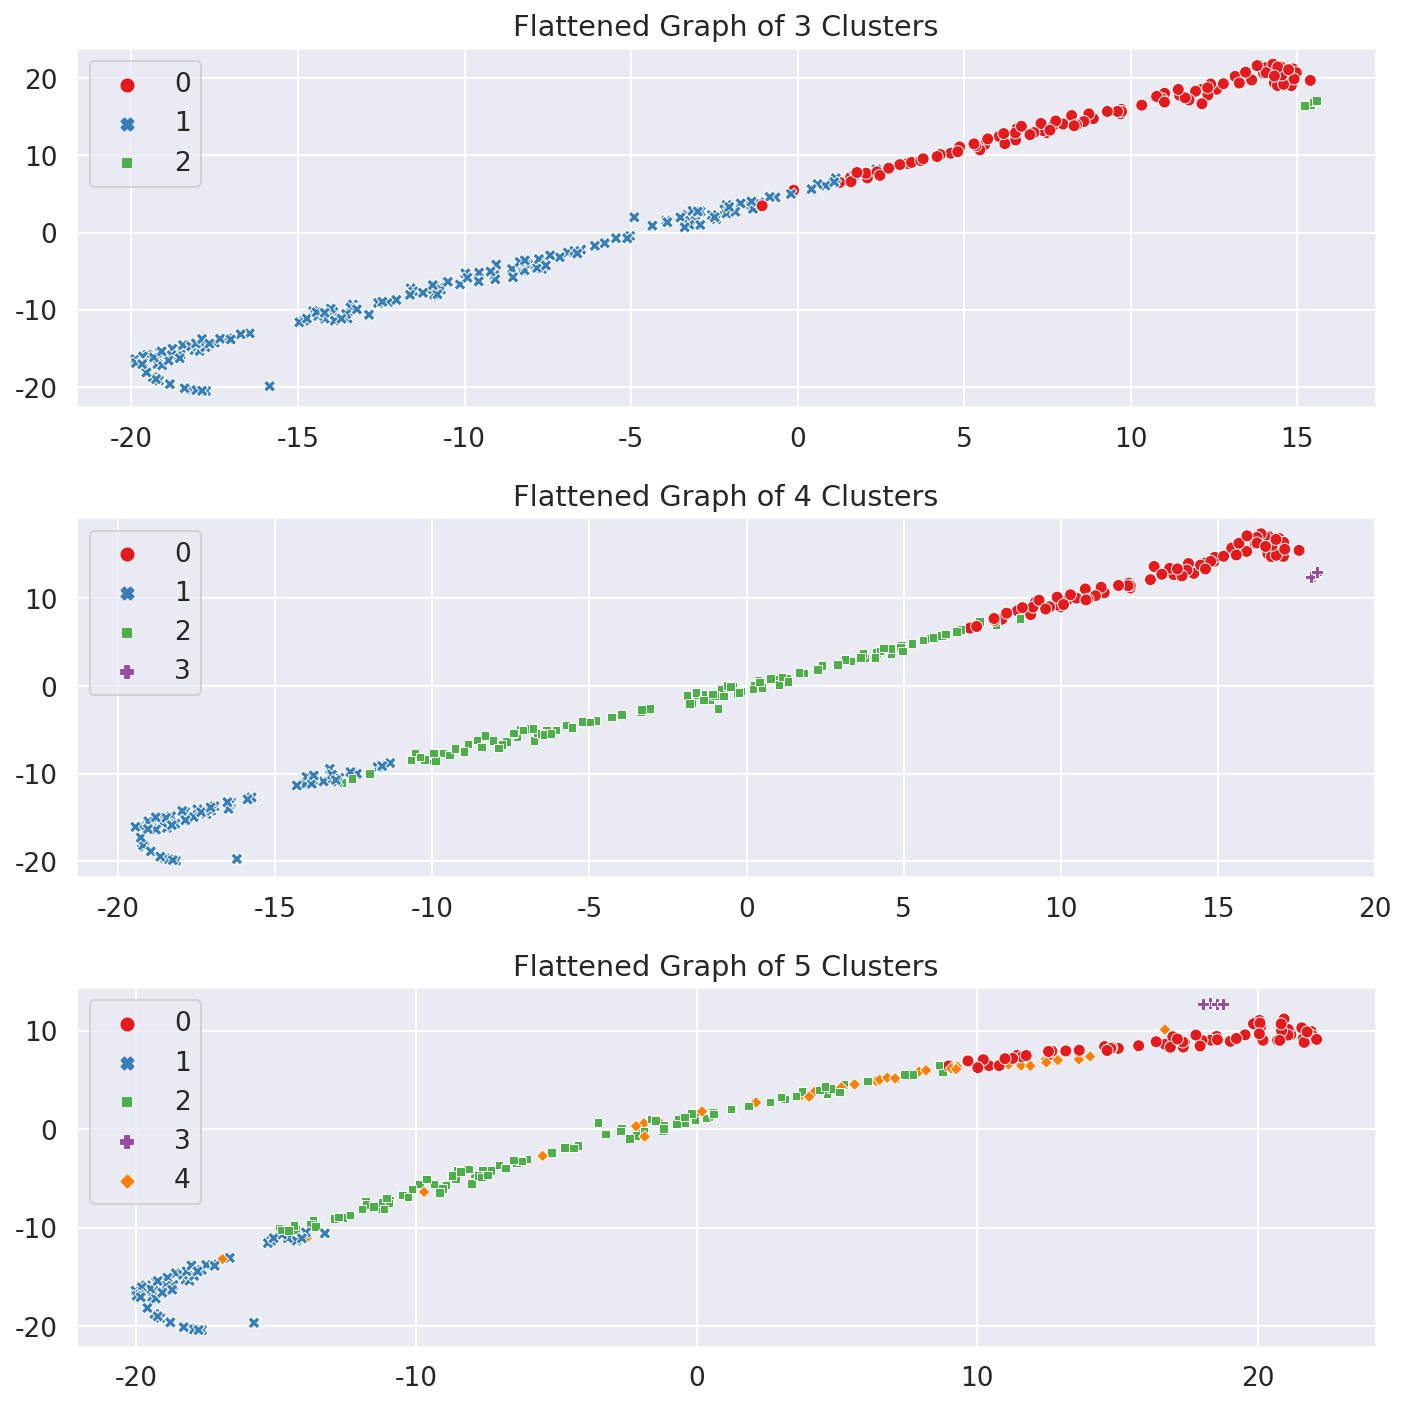

In [ ]:
def kmeans(normalised_df_rfm, clusters_number, original_df_rfm):
    
    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(normalised_df_rfm)
# Extract cluster labels
    cluster_labels = kmeans.labels_
        
    # Create a cluster label column in original dataset
    df_new = original_df_rfm.assign(Cluster = cluster_labels)
    
    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)
    
    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")
    
    return df_new
plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 1)
df_rfm_k3 = kmeans(rfm_normalized, 3, rfm)
plt.subplot(3, 1, 2)
df_rfm_k4 = kmeans(rfm_normalized, 4, rfm)
plt.subplot(3, 1, 3)
df_rfm_k5 = kmeans(rfm_normalized, 5, rfm)
plt.tight_layout()

In [ ]:
rfm

,recency,frequency,monetary,Recency_log,Frequency_log,Monetary_log,clusters_3,clusters_4,clusters_5
channel_name_secured,,,,,,,,,
Co***,200,149,65.51826,5.30330,5.01064,4.19748,0,0,0
KL***,196,128,80.12656,5.28320,4.85981,4.39601,1,0,3
ON**************,200,2006,583.81465,5.30330,7.60440,6.37129,0,2,4
Ye***,202,2026,513.88859,5.31321,7.61431,6.24395,0,2,4
_두***,193,21,7.19008,5.26786,3.09104,2.10292,1,1,3
...,...,...,...,...,...,...,...,...,...
💖나**,201,2385,672.80754,5.30827,7.77737,6.51294,0,2,4
💚마********,200,2791,1082.41224,5.30330,7.93451,6.98787,0,2,4
💜다********,196,171,56.46969,5.28320,5.14749,4.05126,1,0,3


In [ ]:
rfm_segmented

,recency,frequency,monetary,Recency_log,Frequency_log,Monetary_log,R_score,F_score,M_score,RFM_Segment,RFM_Score
channel_name_secured,,,,,,,,,,,
Co***,200,149,65.51826,5.30330,5.01064,4.19748,3,3,3,333,9
KL***,196,128,80.12656,5.28320,4.85981,4.39601,4,3,3,433,10
ON**************,200,2006,583.81465,5.30330,7.60440,6.37129,3,1,1,311,5
Ye***,202,2026,513.88859,5.31321,7.61431,6.24395,2,1,1,211,4
_두***,193,21,7.19008,5.26786,3.09104,2.10292,4,4,4,444,12
...,...,...,...,...,...,...,...,...,...,...,...
💖나**,201,2385,672.80754,5.30827,7.77737,6.51294,3,1,1,311,5
💚마********,200,2791,1082.41224,5.30330,7.93451,6.98787,3,1,1,311,5
💜다********,196,171,56.46969,5.28320,5.14749,4.05126,4,3,3,433,10
